In [2]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
import PIL.Image as Image
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
print(tf.version.VERSION)

2.8.0


In [3]:
path = 'BilletesMexico'
data_path = path+"/BilletesMexico_img"
weights_path = path+'/weights'
numpy_path= path+'/np'
IMG_SIZE =  (224,224)
latent_dim = 100
BATCH_SIZE = 128

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_path),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_path),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE
)

Found 17907 files belonging to 5 classes.
Using 14326 files for training.
Found 17907 files belonging to 5 classes.
Using 3581 files for validation.


In [5]:
class_names = np.array(train_ds.class_names)
print(class_names)
num_classes = len(class_names)



['100' '20' '200' '50' '500']


In [6]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:

movilenet =hub.KerasLayer('https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4')
movilenet.trainable=False


# modelo 1

In [7]:
model = tf.keras.Sequential([
                            #layers.RandomFlip("horizontal_and_vertical"),
                            #layers.RandomRotation(0.2),
                            #layers.RandomContrast(.2),
                            #layers.RandomBrightness(.2),
                            #layers.RandomZoom(.2),
                           # hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", output_shape=[1001],trainable=False),
                            hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v3/classification/5",trainable=False),
                            #movilenet,
                            tf.keras.layers.Dense(int(1001/num_classes)),
                            tf.keras.layers.Dense(num_classes)
                           

                            ])


model.build([None, 224, 224, 3])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              23853833  
                                                                 
 dense (Dense)               (None, 200)               200400    
                                                                 
 dense_1 (Dense)             (None, 5)                 1005      
                                                                 
Total params: 24,055,238
Trainable params: 201,405
Non-trainable params: 23,853,833
_________________________________________________________________


In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])


# pretrained


In [9]:
model.load_weights((weights_path+'/weights2'))

# train


In [14]:
model.fit(train_ds,
            validation_data=val_ds,
            epochs=30)
            

Epoch 1/30
112/112 [==============================] - 51s 342ms/step - loss: 0.7923 - acc: 0.7865 - val_loss: 0.4684 - val_acc: 0.8472
Epoch 2/30
112/112 [==============================] - 33s 292ms/step - loss: 0.4040 - acc: 0.8689 - val_loss: 0.3798 - val_acc: 0.8741
Epoch 3/30
112/112 [==============================] - 33s 291ms/step - loss: 0.3405 - acc: 0.8910 - val_loss: 0.3805 - val_acc: 0.8735
Epoch 4/30
112/112 [==============================] - 33s 291ms/step - loss: 0.3149 - acc: 0.8969 - val_loss: 0.3886 - val_acc: 0.8799
Epoch 5/30
112/112 [==============================] - 33s 292ms/step - loss: 0.2916 - acc: 0.9032 - val_loss: 0.3701 - val_acc: 0.8802
Epoch 6/30
112/112 [==============================] - 33s 293ms/step - loss: 0.2735 - acc: 0.9118 - val_loss: 0.3271 - val_acc: 0.8992
Epoch 7/30
112/112 [==============================] - 33s 292ms/step - loss: 0.2507 - acc: 0.9169 - val_loss: 0.3618 - val_acc: 0.8897
Epoch 8/30
112/112 [==============================] - 3

In [19]:
model.save_weights(weights_path+'/weights2')

# results

(224, 224, 3)


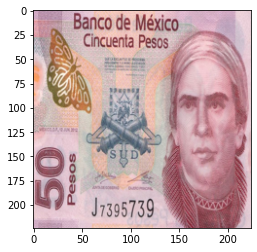

In [18]:

img = Image.open('test.jpg').resize((224,224))
img =  np.array(img)/255.0
print(img.shape)
plt.imshow(img)

In [15]:
result = model.predict(img[np.newaxis,...])
result.shape
predicted_class = tf.math.argmax(result[0], axis=-1)
class_names[int(predicted_class)]

'50'

In [22]:
def get_prediction(img):
    img =  np.array(img)/255.0
    #print(img.shape)
    #plt.imshow(img)
    result = model.predict(img[np.newaxis,...])
    result.shape
    predicted_class = tf.math.argmax(result[0], axis=-1)
    return class_names[int(predicted_class)]

In [20]:
img = Image.open('test.jpg').resize((224,224))

get_prediction(img)

(224, 224, 3)


'50'

# camera input

In [26]:
import cv2


def funcion(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray = cv2.GaussianBlur(gray, (21, 21), 0)

  ret, imgt = cv2.threshold(gray, 138, 255, cv2.THRESH_BINARY_INV)

  cv2.imshow("Image threshold", imgt)
  countours, hierarchy = cv2.findContours(imgt.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  rectangles = [cv2.boundingRect(countour) for countour in countours]
  c = 0
  for i , rect in enumerate(rectangles):
    if rect[2] > 100 and rect[3] > 100:
      imgn = img[rect[1]:rect[1] + rect[3], rect[0]:rect[0] + rect[2]]
      imgn = cv2.resize(imgn, (100, 100))
      c += 1  

      cv2.rectangle(img, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (255, 0, 0), 2)
      cv2.putText(img, str(get_prediction(imgn)), (rect[0], rect[1]), cv2.FONT_HERSHEY_SIMPLEX, 1, (200, 0, 0), 3, cv2.LINE_AA)
  return img

cam = cv2.VideoCapture(0)
while True:
    val, img = cam.read()
    img = funcion(img)
    cv2.imshow("Image funcion",img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cam.release()
cv2.destroyAllWindows()

# imgae augmentation

In [6]:
import Augmentor
# Passing the path of the image directory
p = Augmentor.Pipeline(data_path)
  
# Defining augmentation parameters and generating 5 samples
p.flip_left_right(0.5)
#p.black_and_white(0.1)
p.rotate(0.3, 10, 10)
p.skew(0.4, 0.5)
p.zoom(probability = 0.2, min_factor = .5, max_factor = 1.5)

p.random_contrast(0.2,min_factor=0.3,max_factor=.9)
p.random_color(.3,min_factor=.5,max_factor=.99)

#p.random_erasing(.1,rectangle_area=.2)
#p.rotate_without_crop(.2,max_left_rotation=10,max_right_rotation=10)
#p.zoom_random(.2,percentage_area=.5)
p.sample(6000)

Initialised with 1782 image(s) found.
Output directory set to BilletesMexico/BilletesMexico_img\output.

Processing <PIL.Image.Image image mode=RGB size=640x480 at 0x18999F2B910>:  26%|██▌       | 1564/6000 [00:18<00:53, 83.09 Samples/s]                     


ValueError: image has wrong mode